In [219]:
using IntervalSets, ModelingToolkit
using Sophon
using Optimization, OptimizationOptimJL, OptimizationOptimisers

@parameters t, x
@variables u(..), v(..)
Dₜ = Differential(t)
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

ν = 0.0025
eqs = [Dₜ(u(t, x)) + v(t, x) * u(t, x) + ν * Dₓ²(v(t, x)) ~ 0,
       Dₓ(u(t, x)) ~ v(t, x)] 

bcs = [u(0, x) ~ cospi(x), v(0, x) ~ -π * sinpi(x),
       u(t, -1.0) ~ u(t, 1.0), 
       v(t, -1.0) ~ v(t, 1.0)]

domain = [t ∈ Interval(0.0, 1.0), x ∈ Interval(-1.0, 1.0)]

@named KdV = PDESystem(eqs, bcs, domain, [t, x], [u(t, x), v(t, x)])

PDESystem
Equations: Equation[0.0025Differential(x)(Differential(x)(v(t, x))) + u(t, x)*v(t, x) + Differential(t)(u(t, x)) ~ 0, Differential(x)(u(t, x)) ~ v(t, x)]
Boundary Conditions: Equation[u(0, x) ~ cospi(x), v(0, x) ~ -3.141592653589793sinpi(x), u(t, -1.0) ~ u(t, 1.0), v(t, -1.0) ~ v(t, 1.0)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..1.0), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x), v(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [220]:
chain = Siren(2, 1; hidden_dims=16, num_layers=6, omega=1f0)
pinn = PINN(u=chain, v=chain)
sampler = BetaRandomSampler(2000, 300)
strategy = NonAdaptiveTraining(1, (50, 50, 20, 20))
prob = Sophon.discretize(KdV, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(u = (layer_1 = (weight = [0.3385425806045532 -0.28269529342651367; 0.17602002620697021 0.07763165235519409; … ; 0.2925611138343811 0.3555442690849304; -0.016296803951263428 -0.09475922584533691], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.3375815153121948 -0.5223849415779114 … -0.4721270203590393 -0.26262789964675903; -0.17940232157707214 0.39816832542419434 … 0.47104185819625854 0.5116860270500183; … ; 0.5516133904457092 0.443037211894989 … 0.4109114408493042 -0.23256485164165497; 0.44637224078178406 -0.3722434639930725 … -0.17891797423362732 0.0940035954117775], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.0006440102006308734 0.13132961094379425 … 0.5210193991661072 0.11864607036113739; 0.27670174837112427 -0.3929702639579773 … -0.24225077033042908 -0.41689997911453247; … ; -0.11001821607351303 0.4596799910068512 … -0.3327694833278656 -0.31453555822372437; 0.0417158305644989 -0.28604608774

In [221]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 228.90259356756263


Loss: 0.26159395534472535


Loss: 0.13187998547351393


Loss: 0.07948831269709768


Loss: 0.05335554536606779


Loss: 0.03153134170616961


Loss: 0.018796565224887485


Loss: 0.010528728848124735


Loss: 0.005638556406885361


Loss: 0.003085273674829143


Loss: 0.0019996632880594175


u: ComponentVector{Float64}(u = (layer_1 = (weight = [-0.44173468838960145 -1.2129627175410842; 0.003139466954476966 0.2545921847169992; … ; 0.07291923134734045 0.027865534270221037; -0.3076826623435309 0.006033591519511801], bias = [-0.006313301065894057; 0.23747436650965167; … ; -0.1555959577610583; -0.15308598662783326;;]), layer_2 = (weight = [0.5701959303549433 -0.47273410827971496 … -0.42853471999348225 -0.3237396635661123; -0.35859927637153 0.35305898587262313 … 0.374739138921183 0.6252551405398743; … ; 0.35019351007768096 0.4568275280425368 … 0.38363660637495983 -0.2899340218295028; 0.4245714741472499 -0.3396985407551183 … -0.12974292459994924 0.05063789983381408], bias = [-0.11468489724189897; -0.07243267682799019; … ; -0.06292780786497999; 0.1441493601008229;;]), layer_3 = (weight = [-0.07241999724660317 0.12338395936834494 … 0.29884792955566647 -0.10611326712688256; -0.018631954786760073 -0.015482939427114244 … -0.29383700429934084 -0.3186725930023221; … ; 0.0152908312940346

In [222]:
using MAT
data = matread("KdV.mat")

usol = data["uu"]

# Grid
t_star = vec(data["tt"])
x_star = vec(data["x"]);

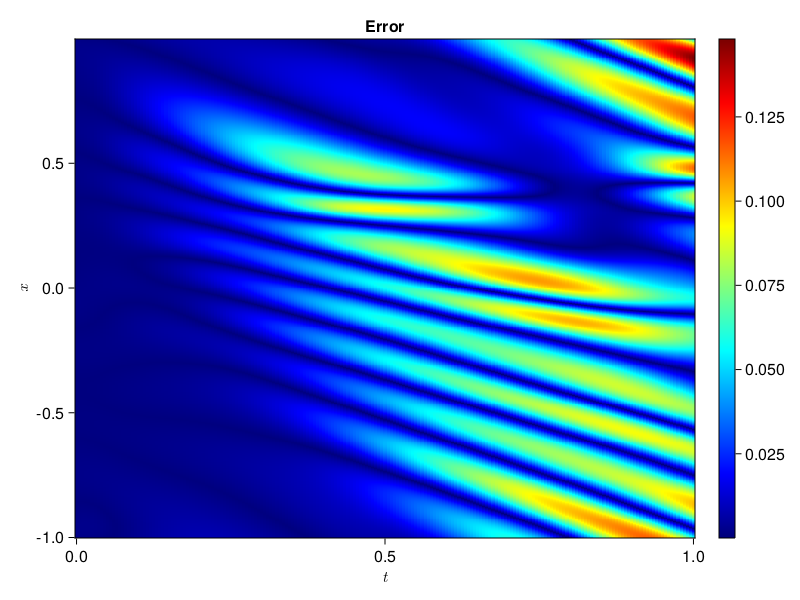

In [223]:
using CairoMakie, MakiePublication

phi = pinn.phi.u
ps = res.u.u

u_pred = [sum(phi([t, x], ps)) for t in t_star, x in x_star]
fig, ax, hm = heatmap(t_star, x_star, abs.(u_pred .- usol');
                      axis=(xlabel=L"t", ylabel=L"x", title="Error"), colormap=:jet)
Colorbar(fig[:, end + 1], hm)
fig

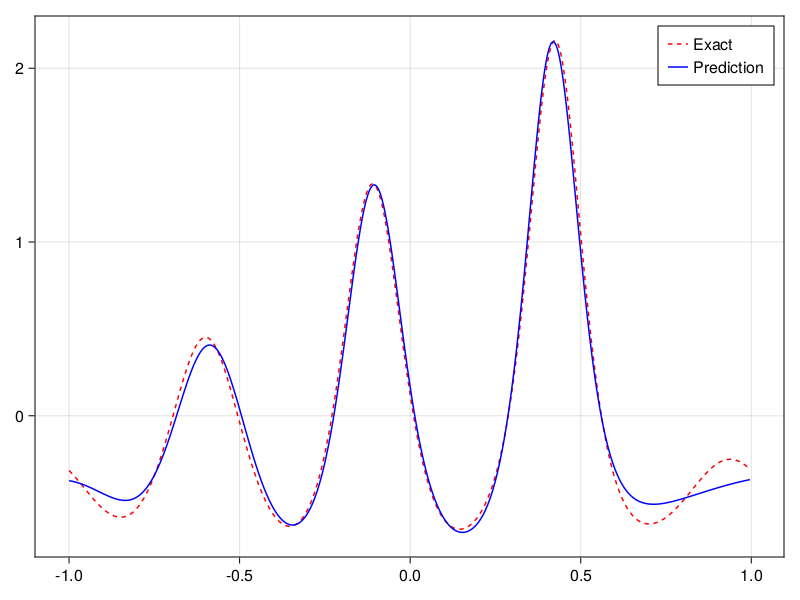

In [227]:
fig = Figure()
axis = Axis(fig[1, 1])
lines!(x_star, usol[:, end], label="Exact", color=:red,  linestyle = :dash)
lines!(x_star, u_pred[end, :], label="Prediction", color=:blue)
axislegend(axis)
fig

Loss: 0.0036906345465353525


Loss: 0.002866034103797553


Loss: 0.00230261332744331


Loss: 0.001724016533495735


Loss: 0.0013642954123681801


Loss: 0.0010995377682565333


Loss: 0.0009086406440658297


Loss: 0.0007736839120495673


Loss: 0.0006559391805689787


Loss: 0.0005552194373870037


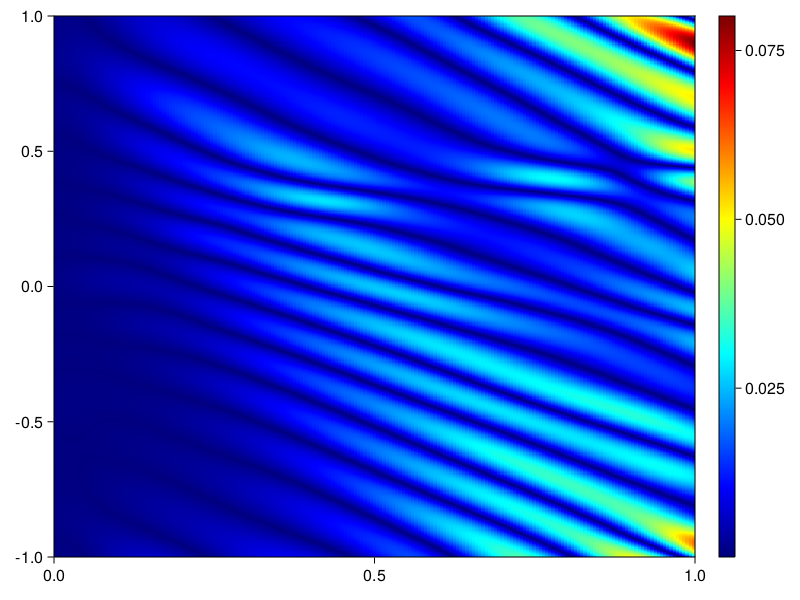

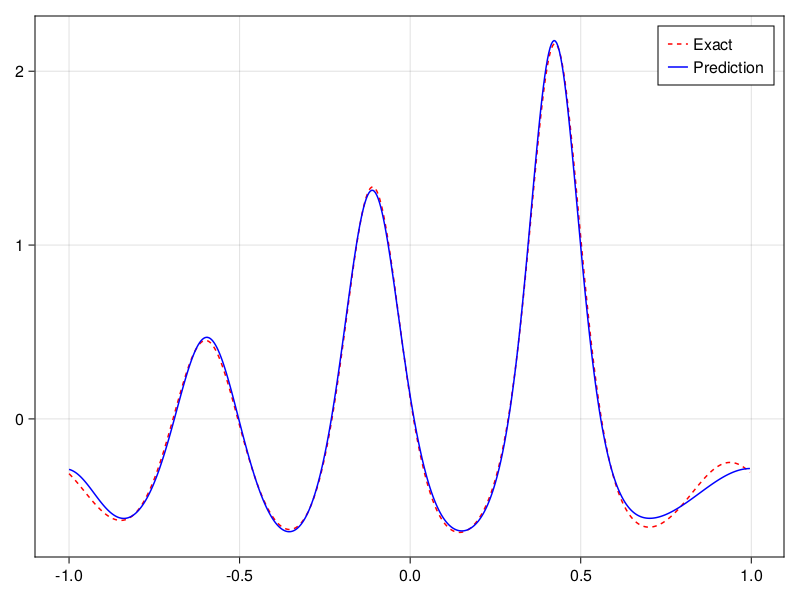

Loss: 0.0004638502993564656


Loss: 0.0015285449503802755


Loss: 0.0008557626965555744


Loss: 0.0006141402690239731


Loss: 0.0004538468473488514


Loss: 0.0003316720046671463


Loss: 0.0002659600754318051


Loss: 0.000226998632647894


Loss: 0.0001862673414053041


Loss: 0.00015403502763246382


Loss: 0.00013288184967462743


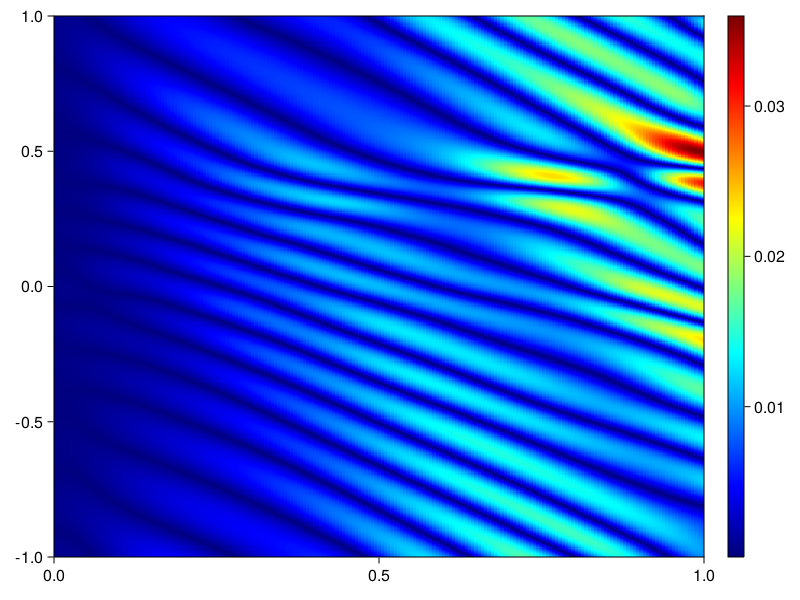

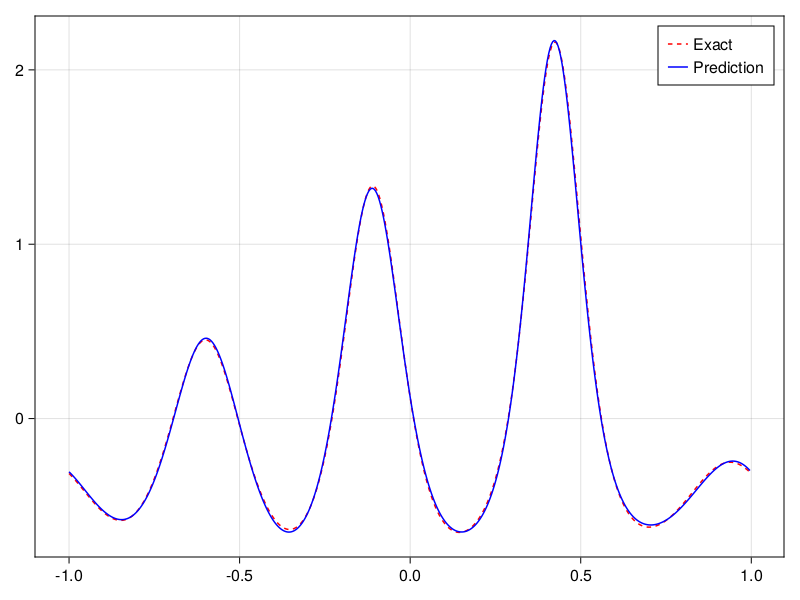

Loss: 0.00011516727858790995


Loss: 0.0002017802400473245


Loss: 0.00014878082121186367


Loss: 0.00011964716643943087


Loss: 0.00010296355119257111


Loss: 9.05437613492346e-5


Loss: 8.043721349810115e-5


Loss: 7.188006791665435e-5


Loss: 6.418063457257951e-5


Loss: 5.850687628794146e-5


Loss: 5.2845807145351945e-5


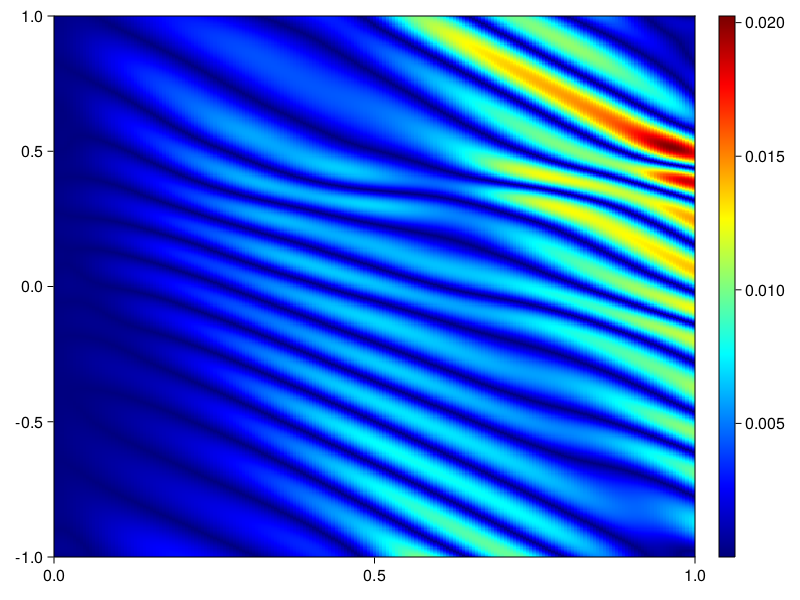

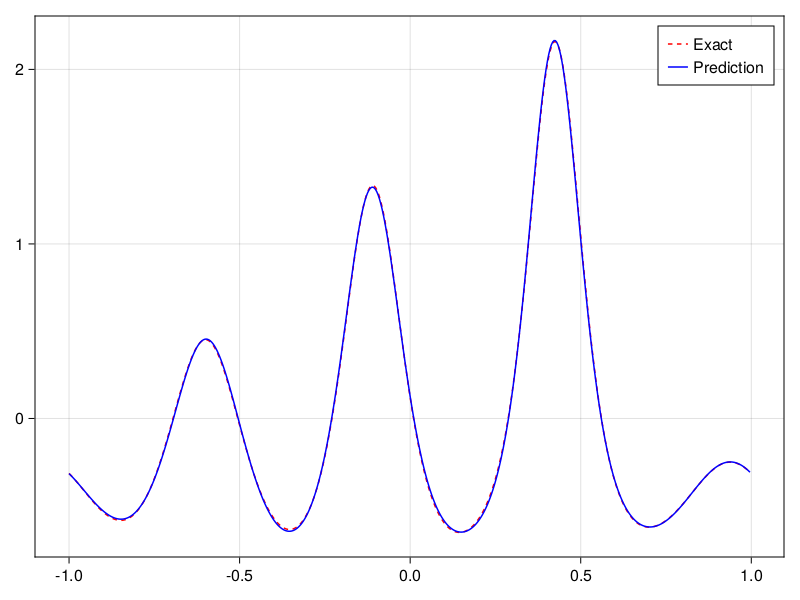

Loss: 4.829519089074831e-5


In [228]:
for α in [0.6, 0.8, 1.0] 
    i=0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(KdV, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(phi([t, x], res.u.u)) for t in t_star, x in x_star]
    fig, ax, hm = heatmap(ts, xs, abs.(usol' .- u_pred), colormap=:jet)
    Colorbar(fig[:, end + 1], hm)
    display(fig)

    fig = Figure()
    axis = Axis(fig[1, 1])
    lines!(x_star, usol[:, end], label="Exact", color=:red,  linestyle = :dash)
    lines!(x_star, u_pred[end, :], label="Prediction", color=:blue)
    axislegend(axis)
    display(fig)
end


Loss: 3.3857809577648e-5


Loss: 2.7988898080386493e-5


Loss: 2.531249064836457e-5


Loss: 2.323090606545701e-5


Loss: 2.1075297302424914e-5


Loss: 1.9146980822819945e-5


Loss: 1.7620007786176872e-5


Loss: 1.607897078397039e-5


Loss: 1.4669796776082212e-5


Loss: 1.3350446050344033e-5


Loss: 1.231482608794598e-5


Loss: 1.1315838390406979e-5


Loss: 1.0392175230548565e-5


Loss: 9.543845053836235e-6


Loss: 8.840842496419447e-6


Loss: 8.2522770215912e-6


Loss: 7.741600659910754e-6


Loss: 7.278846407910512e-6


Loss: 6.864309739487568e-6


Loss: 6.501604115593113e-6


Loss: 6.187814759000314e-6


Loss: 5.889653560266287e-6


Loss: 5.634360873557937e-6


Loss: 5.365474263382001e-6


Loss: 5.137653110748715e-6


Loss: 4.91823804761688e-6


Loss: 4.6894450184522e-6


Loss: 4.4926524097270506e-6


Loss: 4.301765729421532e-6


Loss: 4.123882705390432e-6


Loss: 3.964055599164625e-6


Loss: 3.821925530561761e-6


Loss: 3.697738934501663e-6


Loss: 3.57833482408166e-6


Loss: 3.4451725952196304e-6


Loss: 3.3421869624632206e-6


Loss: 3.2524706269068544e-6


Loss: 3.1484984150771608e-6


Loss: 3.0566613690393843e-6


Loss: 2.9683027392823134e-6


Loss: 2.8869031534198706e-6


Loss: 2.8091590235221215e-6


Loss: 2.7421729649394e-6


Loss: 2.689550390165827e-6


Loss: 2.626776710217949e-6


Loss: 2.557722102267533e-6


Loss: 2.4928319914782596e-6


Loss: 2.434015888677591e-6


Loss: 2.3704130655030534e-6


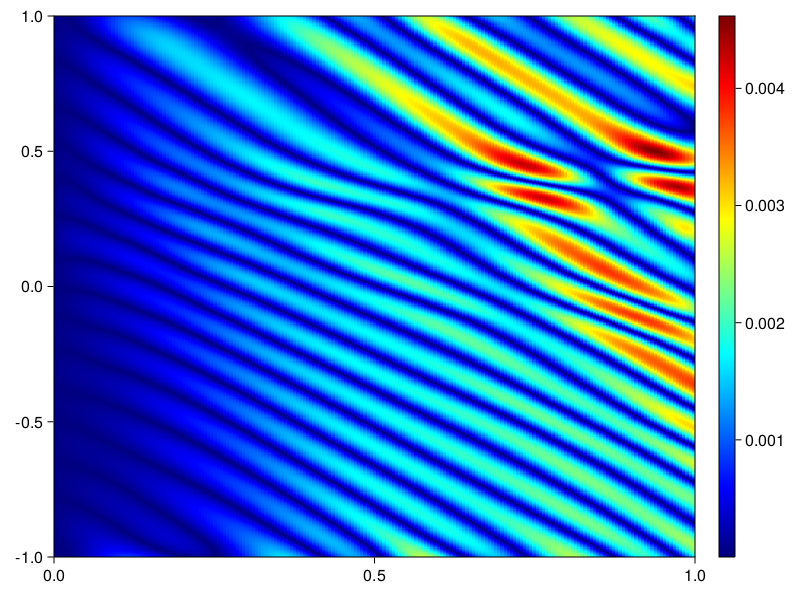

Loss: 2.3085071008696046e-6


CairoMakie.Screen{IMAGE}


In [230]:
sampler = QuasiRandomSampler(2000, 300)
data = Sophon.sample(KdV, sampler)
prob = remake(prob; p=data, u0=res.u)
res = Optimization.solve(prob, BFGS(); maxiters=5000, callback=callback)

u_pred = [sum(phi([t, x], res.u.u)) for t in t_star, x in x_star]
    fig, ax, hm = heatmap(ts, xs, abs.(usol' .- u_pred), colormap=:jet)
    Colorbar(fig[:, end + 1], hm)
    display(fig)

In [232]:
using JLD2
jldsave("KdV.jld2"; pde=KdV, phi=pinn.phi, res=res, prob=prob)